In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import callbacks
import warnings
import joblib
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [5]:
df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [6]:
df["accident"].fillna("None reported", inplace=True)
df["clean_title"].fillna("No", inplace=True)
df["fuel_type"].fillna("No Data", inplace=True)

In [7]:
df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [8]:
df.nunique()

id              188533
brand               57
model             1897
model_year          34
milage            6651
fuel_type            8
engine            1117
transmission        52
ext_col            319
int_col            156
accident             2
clean_title          2
price             1569
dtype: int64

In [9]:
df = df.drop(['id'], axis=1)

In [10]:
X = df.drop(['price'], axis=1)

In [11]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

In [12]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols].astype(str))

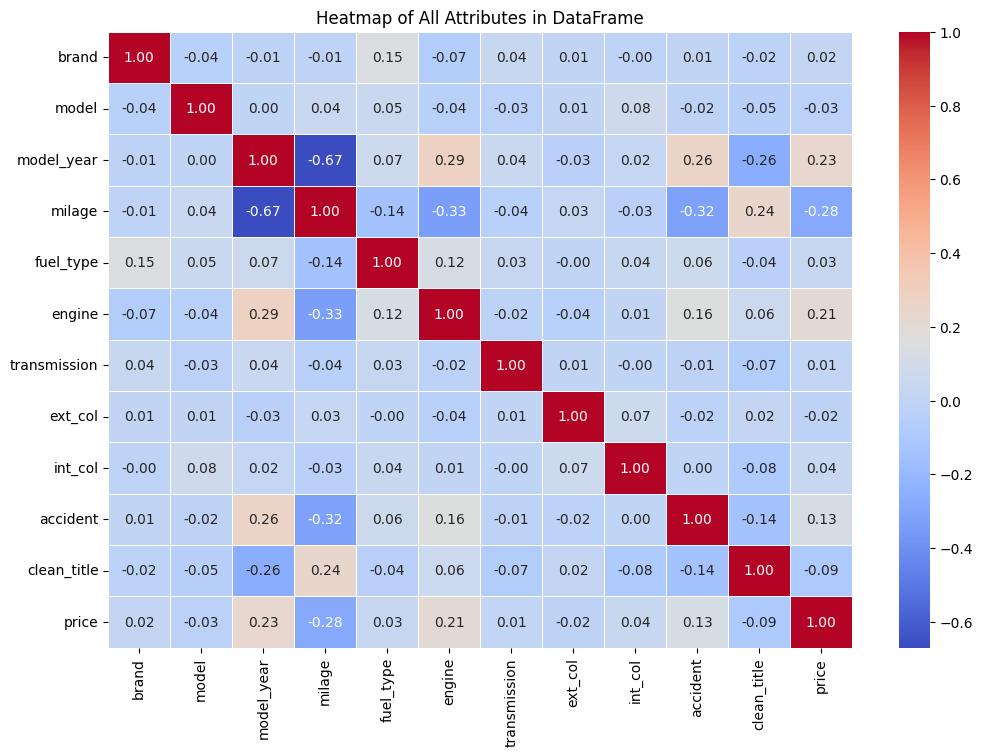

In [13]:
corr_df = df.copy()
correlation_matrix = corr_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of All Attributes in DataFrame")
plt.show()

In [14]:
X = df.drop(['price'], axis=1)
y = df['price']

In [19]:
model = keras.Sequential()

# Input layer
model.add(Input(shape=(X.shape[1],)))

# Hidden layers
model.add(Dense(128, activation=None))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(64, activation=None))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dense(32, activation=None))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='linear'))

model.compile(optimizer=AdamW(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(
    X, y,
    validation_split=0.25,
    epochs=150,
    batch_size=64,
    verbose=0
)

train_loss, train_mse = model.evaluate(X, y, verbose=0)
print(f"Train MSE: {train_mse:.4f}")

y_pred_train = model.predict(X)

train_mse = mean_squared_error(y, y_pred_train)
print(f"Final Train MSE: {train_mse:.4f}")

Train MSE: 5464482304.0000
5892/5892 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
Final Train MSE: 5464479812.7530


In [25]:
rmse = np.sqrt(train_mse)
print(f"Final Train RMSE: {rmse:.4f}")

Final Train RMSE: 73922.1199


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [21]:
test.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [22]:
test["accident"].fillna("None reported", inplace=True)
test["clean_title"].fillna("No", inplace=True)
test["fuel_type"].fillna("No Data", inplace=True)

In [23]:
test[numerical_cols] = scaler.transform(test[numerical_cols])
test[categorical_cols] = ordinal_encoder.transform(test[categorical_cols].astype(str))

In [26]:
test = test.drop(['id'], axis=1)

In [27]:
y_pred = model.predict(test)

3928/3928 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


In [29]:
sub['price'] = y_pred

In [30]:
sub.to_csv('submission.csv', index=False)

In [28]:
y_pred

array([[19987.861],
       [61595.69 ],
       [57732.164],
       ...,
       [26005.195],
       [20140.033],
       [32433.852]], dtype=float32)